# AUC and Gini decomposition

This notebook implements the methods described in the paper and proposes a Gini score decomposition.

Author: https://github.com/deburky

Paper source: [Decomposing Global AUC into Cluster-Level Contributions for Localized Model Diagnostics](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5386496).


In [1]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score

%config InlineBackend.figure_format = 'retina'

## AUC decomposition

In [2]:
# Create a more varied dataset for 3 clusters with mixed scores
random.seed(42)

data = []
clusters = ["C1", "C2", "C3"]

# Generate data: 5 positives and 5 negatives per cluster with random scores
for cluster in clusters:
    data.extend(
        {
            "cluster": cluster,
            "label": 1,
            "score": round(random.uniform(0.4, 0.95), 2),
        }
        for _ in range(5)
    )
    data.extend(
        {
            "cluster": cluster,
            "label": 0,
            "score": round(random.uniform(0.2, 0.7), 2),
        }
        for _ in range(5)
    )
df = pd.DataFrame(data)


# Function to compute AUC (pairwise probability)
def auc_pairwise(pos_scores, neg_scores):
    if len(pos_scores) == 0 or len(neg_scores) == 0:
        return None
    total_pairs = len(pos_scores) * len(neg_scores)
    wins = 0
    for ps in pos_scores:
        for ns in neg_scores:
            if ps > ns:
                wins += 1
            elif ps == ns:
                wins += 0.5
    return wins / total_pairs


# Compute intra/inter-cluster AUC matrix
auc_matrix = pd.DataFrame(index=clusters, columns=clusters, dtype=float)
for ci in clusters:
    for cj in clusters:
        pos_scores = df[(df["cluster"] == ci) & (df["label"] == 1)]["score"]
        neg_scores = df[(df["cluster"] == cj) & (df["label"] == 0)]["score"]
        auc_matrix.loc[ci, cj] = auc_pairwise(pos_scores, neg_scores)

# Compute global AUC
global_auc = auc_pairwise(df[df["label"] == 1]["score"], df[df["label"] == 0]["score"])

auc_matrix, global_auc

(      C1   C2    C3
 C1  0.78  0.8  0.84
 C2  0.74  0.8  0.84
 C3  0.88  0.9  0.88,
 0.8288888888888889)

In [3]:
(auc_matrix,)

(      C1   C2    C3
 C1  0.78  0.8  0.84
 C2  0.74  0.8  0.84
 C3  0.88  0.9  0.88,)

In [4]:
# Compute ROC AUC using sklearn for the whole dataset
global_auc_sklearn = roc_auc_score(df["label"], df["score"])

(global_auc, global_auc_sklearn), (global_auc == global_auc_sklearn)
# ((0.8288888888888889, 0.8288888888888889), True)

((0.8288888888888889, 0.8288888888888889), True)

## Gini score decomposition

In [5]:
def gini_pairwise(pos_scores, neg_scores):
    if len(pos_scores) == 0 or len(neg_scores) == 0:
        return None
    total_pairs = len(pos_scores) * len(neg_scores)
    net = 0.0
    for ps in pos_scores:
        for ns in neg_scores:
            if ps > ns:
                net += 1  # concordant
            elif ps < ns:
                net -= 1  # discordant
            # ties contribute 0
    return net / total_pairs


# Compute intra/inter-cluster Gini/Somers' D matrix
gini_matrix = pd.DataFrame(index=clusters, columns=clusters, dtype=float)
for ci in clusters:
    for cj in clusters:
        pos_scores = df[(df["cluster"] == ci) & (df["label"] == 1)]["score"]
        neg_scores = df[(df["cluster"] == cj) & (df["label"] == 0)]["score"]
        gini_matrix.loc[ci, cj] = gini_pairwise(pos_scores, neg_scores)

# Compute global Gini
global_gini = gini_pairwise(
    df[df["label"] == 1]["score"], df[df["label"] == 0]["score"]
)

gini_matrix, global_gini

(      C1   C2    C3
 C1  0.56  0.6  0.68
 C2  0.48  0.6  0.68
 C3  0.76  0.8  0.76,
 0.6577777777777778)

In [6]:
(gini_matrix,)

(      C1   C2    C3
 C1  0.56  0.6  0.68
 C2  0.48  0.6  0.68
 C3  0.76  0.8  0.76,)

In [7]:
(
    (global_gini, global_auc_sklearn * 2 - 1),
    (global_gini == global_auc_sklearn * 2 - 1),
)

((0.6577777777777778, 0.6577777777777778), True)

## Real-world credit risk example

In [8]:
path_to_data = (
    "https://raw.githubusercontent.com/deburky/boosting-scorecards/"
    "refs/heads/main/rfgboost/BankCaseStudyData.csv"
)
df = pd.read_csv(path_to_data)

df["Occupation_Code"] = df["Occupation_Code"].map(
    {"O": "Other", "P": "Pensioner", "B": "Self-employed", "M": "Employee"}
)

df["Residential_Status"] = df["Residential_Status"].map(
    {"H": "Homeowner", "L": "Living with parents", "O": "Other", "T": "Tenant"}
)

df["is_default"] = df["Final_Decision"].map({"Accept": 0, "Decline": 1})

# Rename columns for plots
df.rename(
    columns={
        "Bureau_Score": "Credit Bureau Score",
        "Application_Score": "Application Score",
        "Gross_Annual_Income": "Gross Annual Income",
    },
    inplace=True,
)

In [9]:
# Pick clusters: here, Occupation groups
clusters = df["Occupation_Code"].unique()


# Function for AUC (already defined)
def auc_pairwise(pos_scores, neg_scores):
    if len(pos_scores) == 0 or len(neg_scores) == 0:
        return None
    total_pairs = len(pos_scores) * len(neg_scores)
    wins = 0
    for ps in pos_scores:
        for ns in neg_scores:
            if ps > ns:
                wins += 1
            elif ps == ns:
                wins += 0.5
    return wins / total_pairs


# Function for Gini / Somers' D (already defined)
def gini_pairwise(pos_scores, neg_scores):
    if len(pos_scores) == 0 or len(neg_scores) == 0:
        return None
    total_pairs = len(pos_scores) * len(neg_scores)
    net = 0.0
    for ps in pos_scores:
        for ns in neg_scores:
            if ps > ns:
                net += 1  # concordant
            elif ps < ns:
                net -= 1  # discordant
            # ties contribute 0
    return net / total_pairs


# AUC decomposition by occupation
auc_matrix = pd.DataFrame(index=clusters, columns=clusters, dtype=float)
gini_matrix = pd.DataFrame(index=clusters, columns=clusters, dtype=float)

for ci in clusters:
    for cj in clusters:
        pos_scores = df[(df["Occupation_Code"] == ci) & (df["is_default"] == 0)][
            "Application Score"
        ]
        neg_scores = df[(df["Occupation_Code"] == cj) & (df["is_default"] == 1)][
            "Application Score"
        ]

        auc_matrix.loc[ci, cj] = auc_pairwise(pos_scores, neg_scores)
        gini_matrix.loc[ci, cj] = gini_pairwise(pos_scores, neg_scores)

# Global metrics
global_auc = auc_pairwise(
    df[df["is_default"] == 0]["Application Score"],
    df[df["is_default"] == 1]["Application Score"],
)

global_gini = gini_pairwise(
    df[df["is_default"] == 0]["Application Score"],
    df[df["is_default"] == 1]["Application Score"],
)

print("Global AUC:", round(global_auc, 3))
print("Global Gini:", round(global_gini, 3))

print("\nAUC matrix by Occupation:")
print(auc_matrix)

print("Gini matrix by Occupation:")
print(gini_matrix.round(2))

Global AUC: 0.925
Global Gini: 0.85

AUC matrix by Occupation:
               Self-employed  Employee  Pensioner     Other
Self-employed       0.912138  0.959841   0.860288  0.968293
Employee            0.854180  0.923623   0.783075  0.939362
Pensioner           0.941713  0.975268   0.902301  0.980643
Other               0.715269  0.817798   0.614021  0.857776
Gini matrix by Occupation:
               Self-employed  Employee  Pensioner  Other
Self-employed           0.82      0.92       0.72   0.94
Employee                0.71      0.85       0.57   0.88
Pensioner               0.88      0.95       0.80   0.96
Other                   0.43      0.64       0.23   0.72


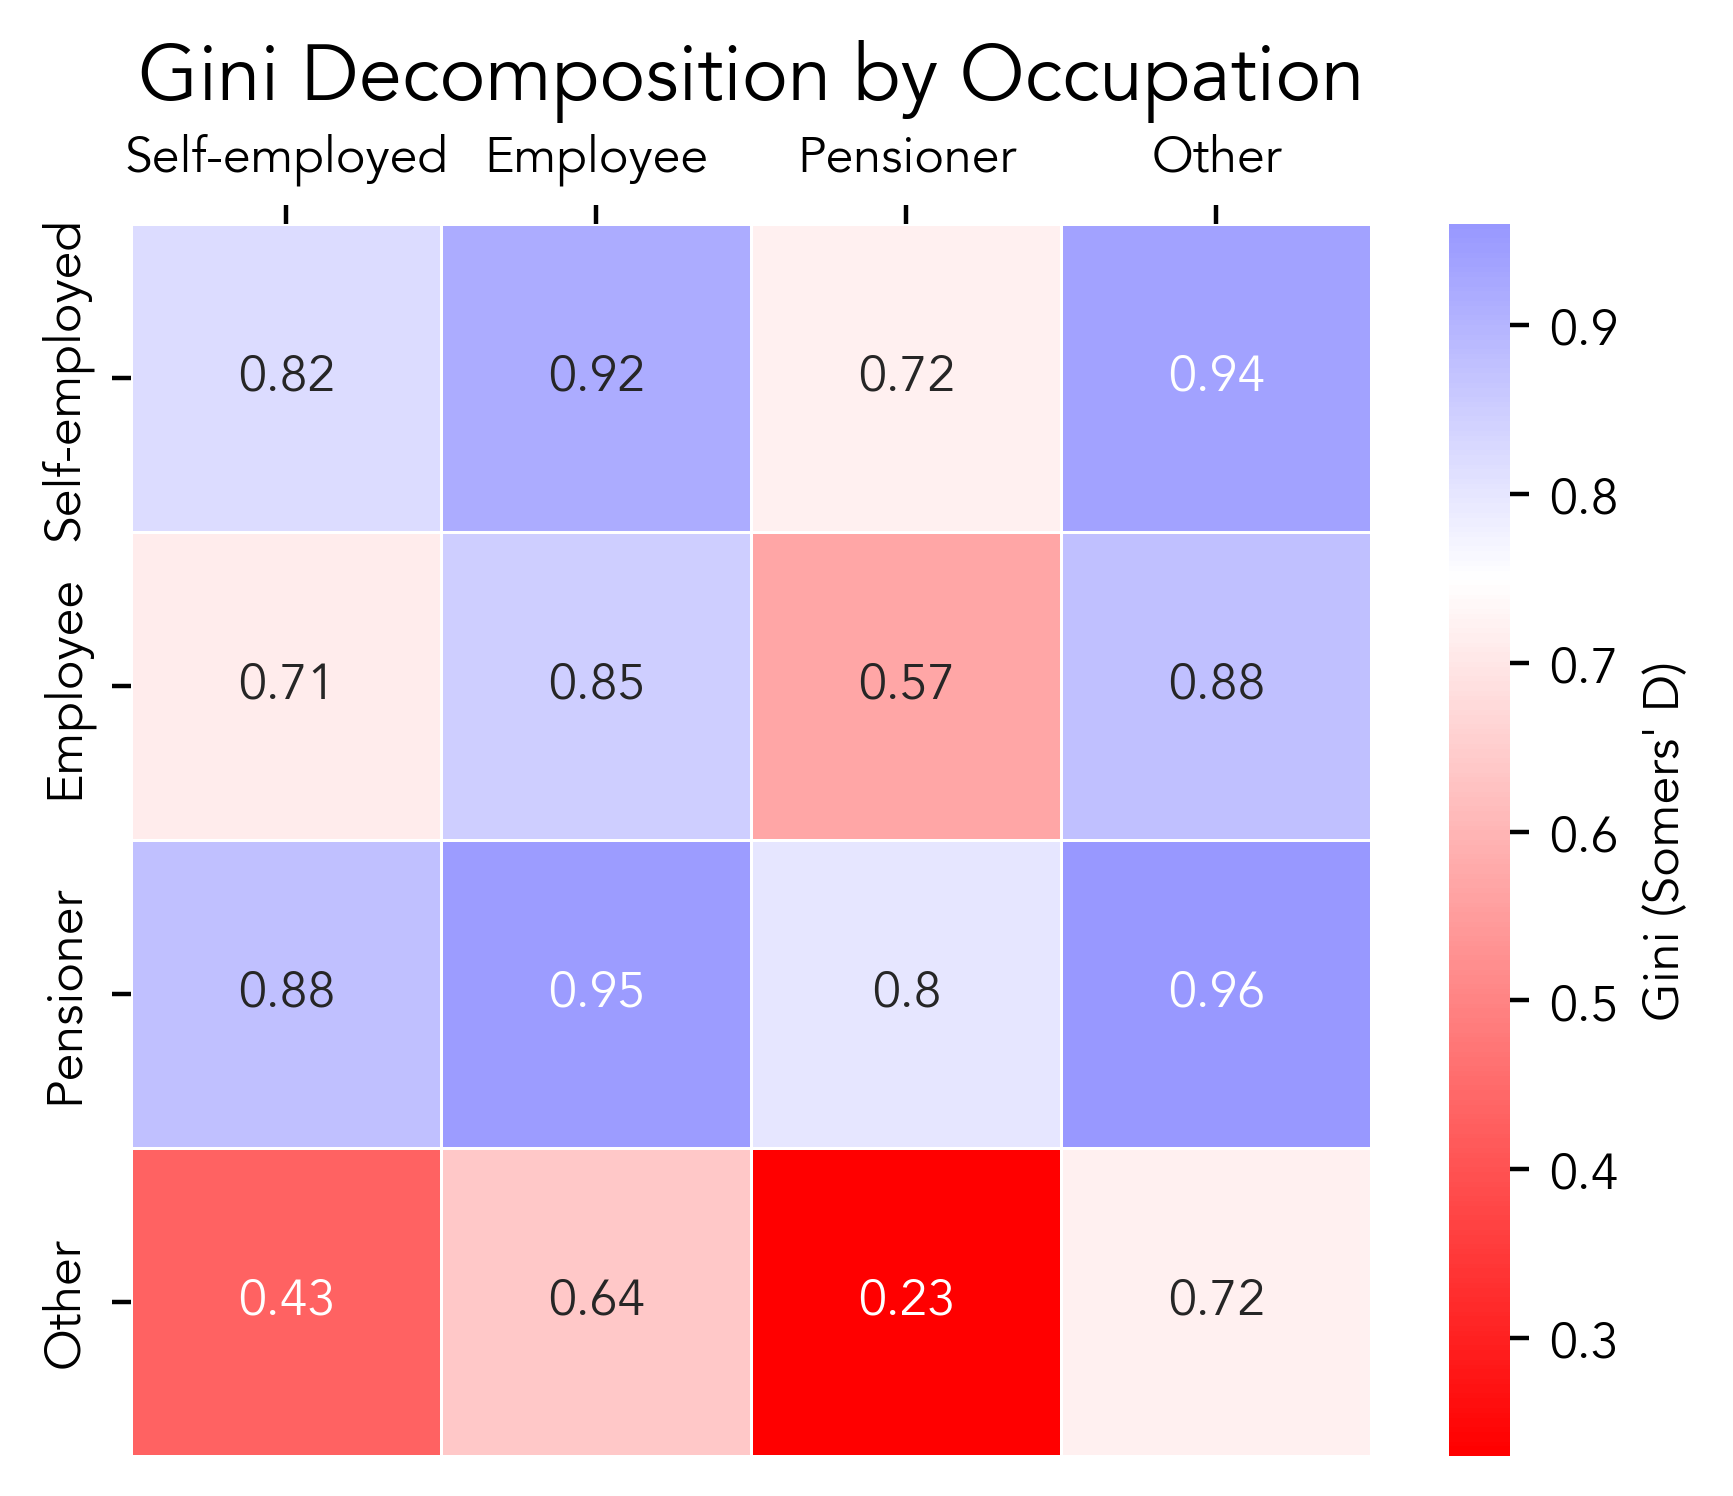

In [10]:
# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 9

# Round values for readability
matrix = gini_matrix.round(2)

plt.figure(figsize=(5, 4), dpi=200)
ax = sns.heatmap(
    matrix.astype(float),
    annot=True,
    cmap="bwr_r",
    center=0.75,
    linewidths=0.5,
    cbar_kws={"label": "Gini (Somers' D)"},
)
plt.title("Gini Decomposition by Occupation", fontsize=14)

# Move x-axis labels to top
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
plt.xlabel("")  # optional: hide bottom xlabel
plt.ylabel("")

plt.show()